In [6]:
import numpy as np
import pandas as pd 

project strcuture 

✔️ Data Design
✔️ KPI Definition
✔️ EDA (What is happening)
✔️ RCA (Why it is happening)
✔️ Decision (What to do)
✔️ Monitoring Plan (Did it work?)

# 🎯 Problem Statement
### Customers using instant delivery e-commerce platforms in Indian cities frequently experience delayed deliveries despite promised delivery times. This project aims to identify delivery delay patterns, determine root causes, recommend data-driven actions, and define a monitoring plan.

# 🧠 PROJECT FLOW
## EDA → RCA → Decision Framework → Monitoring Plan
### EDA → trends & patterns
### RCA → why delays happen
### Decision → what to fix
### Monitoring → KPIs


## STEP 1️⃣ — CREATE SYNTHETIC DATA

In [2]:
import numpy as np 
import pandas as pd 

## Generate data (REALISTIC LOGIC)

In [7]:
np.random.seed(42)

n = 10000

df = pd.DataFrame({
    "order_id": range(1, n+1),
    "order_date": pd.date_range("2024-01-01", periods=n, freq="H"),
    "city": np.random.choice(
        ["Bangalore", "Delhi", "Mumbai", "Hyderabad"],
        size=n,
        p=[0.35, 0.25, 0.25, 0.15]
    ),
    "order_hour": np.random.randint(0, 24, n),
    "promised_minutes": np.random.choice([10, 15, 20], size=n, p=[0.4, 0.4, 0.2]),
    "traffic_level": np.random.choice(
        ["Low", "Medium", "High"],
        size=n,
        p=[0.3, 0.45, 0.25]
    ),
    "weather": np.random.choice(
        ["Clear", "Rain"],
        size=n,
        p=[0.8, 0.2]
    ),
    "rider_available": np.random.choice(
        ["Yes", "No"],
        size=n,
        p=[0.9, 0.1]
    )
})


C:\Users\mm428\AppData\Local\Temp\ipykernel_752\4045762470.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "order_date": pd.date_range("2024-01-01", periods=n, freq="H"),


In [4]:
df.head()

,order_id,order_date,city,order_hour,promised_minutes,traffic_level,weather,rider_available
0,1,2024-01-01 00:00:00,Delhi,22,10,High,Clear,Yes
1,2,2024-01-01 01:00:00,Hyderabad,3,15,Low,Clear,Yes
2,3,2024-01-01 02:00:00,Mumbai,17,15,Medium,Clear,Yes
3,4,2024-01-01 03:00:00,Delhi,4,20,Low,Clear,Yes
4,5,2024-01-01 04:00:00,Bangalore,15,10,Low,Clear,Yes


In [8]:
# Add peak hour flag 
df['peak_hour'] = df['order_hour'].between(18,22)
# explain any order_hour value b/w 18-22 is true otherethen false 

In [9]:
df[['order_hour','peak_hour']]

,order_hour,peak_hour
0,22,True
1,3,False
2,17,False
3,4,False
4,15,False
...,...,...
9995,22,True
9996,5,False
9997,21,True
9998,2,False


## Generate actual delivery time (THIS IS KEY)

In [10]:
base_time = df['promised_minutes']

In [11]:
traffic_delay = df['traffic_level'].map({
    "Low": 0,
    "Medium": 5,
    "High" : 12 
})

weather_delay = df['weather'].map({
    "Clear" : 0 ,
    "Rain": 8 
})

rider_delay = df['rider_available'].map({
    "Yes":0,
    "No":8
})

peak_delay = df['peak_hour'].map({
    True : 6,
    False : 0
})

df["actual_delivery_minutes"] = (
    base_time+
    traffic_delay+
    weather_delay+
    rider_delay+
    peak_delay+
    np.random.normal(0,3,n) # # real-life randomness 
).round(1)

In [12]:
# Create delay metric (MAIN KPI) 
df["delay_minutes"] = (
    df["actual_delivery_minutes"] - df["promised_minutes"]
)


# STEP 2️⃣ — DEFINE CORE KPIs

| KPI               | Formula                       | Why           |
| ----------------- | ----------------------------- | ------------- |
| Avg delivery time | mean(actual_delivery_minutes) | Speed         |
| Delay rate        | % delay_minutes > 0           | Reliability   |
| Avg delay         | mean(delay_minutes)           | Customer pain |
| On-time %         | % delay_minutes ≤ 0           | SLA       
   |


## We are measuring delivery performance from four angles

#### Speed → Reliability → Customer Pain → SLA Compliance


### 1️⃣ Avg Delivery Time (Speed)
##### Business Question
##### “On average, how long does delivery actually take?”
##### formula :-Avg Delivery Time = mean(actual_delivery_minutes)


In [13]:
avg_delivery_time = df["actual_delivery_minutes"].mean()
print(f"“On average, a customer receives their order in {avg_delivery_time.round(2)} minutes")


“On average, a customer receives their order in 22.87 minutes


### Business interpretation

“On average, a customer receives their order in X minutes.”

If this number is much higher than promised (10–20 min) → expectations are broken.

### 2️⃣ Delay Rate (Reliability)
##### 🔹 Business Question
##### “How often do we fail to meet the promised time?”
#### fromula:- Delay Rate = % of orders where delay_minutes > 0


In [14]:
delay_rate = (df["delay_minutes"] > 0).mean()
print(delay_rate)
delay_rate_pct = delay_rate * 100
print(f"delay_percentage of orders {delay_rate_pct.round(0)} %")

print(f"\n {delay_rate_pct.round(0)}% of orders are delayed \n This is a trust & reliability metric ")

0.896
delay_percentage of orders 90.0 %

 90.0% of orders are delayed 
 This is a trust & reliability metric 


# 3️⃣ Avg Delay (Customer Pain)
### 🔹 Business Question
##### “When delays happen, how bad are they?”
##### formula:- Avg Delay = mean(delay_minutes)


In [26]:
#What we are calculating

'''Average deviation from promised time
(early deliveries are negative, late are positive)'''

avg_delay = df["delay_minutes"].mean()
print(f" When we fail customers wait {avg_delay.round(2)} extra minutes ")


avg_delay_late = df.loc[
    df["delay_minutes"] > 0,
    "delay_minutes"
].mean()

avg_delay_late


 When we fail customers wait 8.79 extra minutes 


10.078627232142855

# KPI 4️⃣ — On-Time Delivery % (SLA Compliance)
### “Out of all the orders, how many were delivered on time (meeting SLA) or even faster (early)?”
#### formula:- On-time % = % of orders where delay_minutes ≤ 0


In [16]:
# What we are calculating
'''Percentage of orders delivered on or before promised time.'''
on_time_rate = (df["delay_minutes"] <= 0).mean()
print(on_time_rate)

on_time_rate_pct = on_time_rate * 100
print(f"{on_time_rate_pct} % of orders meet SLA")


0.104
10.4 % of orders meet SLA


In [17]:
# Consistency Check (VERY IMPORTANT) 
on_time_rate + delay_rate


1.0

In [28]:
kpi_summary = pd.DataFrame({
    "KPI": [
        "Avg Delivery Time",
        "Delay Rate",
        "Avg Delay (All Orders)",
        "Avg Delay (Late Orders)",
        "On-Time %"
    ],
    "Value": [
        avg_delivery_time,
        delay_rate_pct,
        avg_delay,
        avg_delay_late,
        on_time_rate_pct
    ]
})

kpi_summary.round(0)


,KPI,Value
0,Avg Delivery Time,23.0
1,Delay Rate,90.0
2,Avg Delay (All Orders),9.0
3,Avg Delay (Late Orders),10.0
4,On-Time %,10.0


## 1️⃣ Average Delivery Time (Speed)
     ### This tells how long customers usually wait for their orders
## 2️⃣ Delay Rate (Reliability) 
    ### This tells how often deliveries are late. 
## 3️⃣ Average Delay (Customer Pain)
    ### This tells how many extra minutes customers usually wait. 
## 4️⃣ On-Time Delivery % (SLA Compliance)
    ### This tells how many orders are delivered on time.

# STEP 3️⃣ — EDA

🎯 EDA Objectives

We want to answer:

Where are delays highest?

When do delays spike?

Under what conditions are delays worse?

How bad is the distribution of delays?

# Question

### Are delays generally small or large? Are extreme delays common?

In [19]:
df["delay_minutes"].describe()


count    10000.000000
mean         8.787390
std          7.098414
min        -10.200000
25%          3.600000
50%          8.300000
75%         13.400000
max         38.200000
Name: delay_minutes, dtype: float64

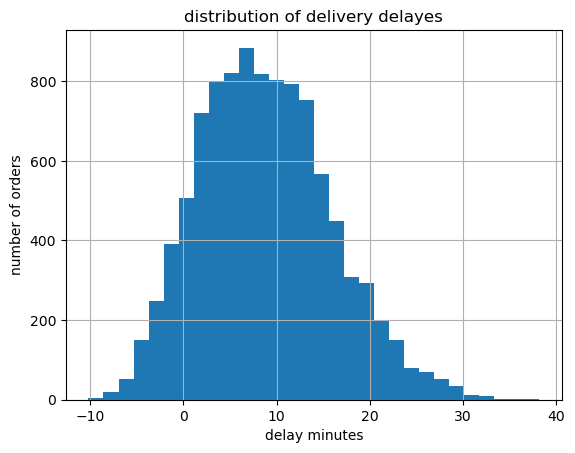

In [44]:
# delay distribution chart 
# how delays are spread and whether extreme delays exist
import matplotlib.pyplot as plt 
plt.figure()
df['delay_minutes'].hist(bins=30)
plt.xlabel("delay minutes")
plt.ylabel("number of orders")
plt.title("distribution of delivery delayes")
plt.show()

# chart obs
Right-skewed distribution → most orders are delayed

Long tail → few customers face very large delays

Confirms systemic SLA failure

# Question

###  Which cities suffer the most delays?

In [33]:
city_eda = (
    df.groupby("city")
      .agg(
          avg_delivery_time=("actual_delivery_minutes", "mean"),
          delay_rate=("delay_minutes", lambda x: (x > 0).mean()),
          avg_delay=("delay_minutes", "mean")
      )
      .reset_index()
      .sort_values("delay_rate", ascending=False)
)

city_eda.round(2)


,city,avg_delivery_time,delay_rate,avg_delay
2,Hyderabad,22.87,0.90,8.77
1,Delhi,22.93,0.90,8.92
0,Bangalore,22.89,0.89,8.80
3,Mumbai,22.77,0.89,8.64


# Question

## Are delays worse during peak hours?

In [34]:
peak_eda = (
    df.groupby("peak_hour")
      .agg(
          avg_delivery_time=("actual_delivery_minutes", "mean"),
          delay_rate=("delay_minutes", lambda x: (x > 0).mean()),
          avg_delay=("delay_minutes", "mean")
      )
      .reset_index()
)

peak_eda


,peak_hour,avg_delivery_time,delay_rate,avg_delay
0,False,21.552804,0.869449,7.469449
1,True,27.759537,0.994806,13.692021


# observation
## Non-Peak Hours (peak_hour = False)
### Avg Delivery Time = 21.55 minutes
Even during non-peak hours, customers wait over 21 minutes, which is already well above the promised 10–15 minutes.

### Delay Rate = 86.9%
Nearly 9 out of 10 orders are delayed even outside peak hours.

### Avg Delay = 7.47 minutes
Customers typically wait 7–8 extra minutes beyond promised time

# Peak Hours (peak_hour = True) 

## Avg Delivery Time = 27.76 minutes

During peak hours, delivery time increases to almost 28 minutes, nearly double the lower promised SLA.

## Delay Rate = 99.5%
 Almost every single order placed during peak hours is delayed.

## Avg Delay = 13.69 minutes
When delays occur in peak hours, customers wait nearly 14 extra minutes.

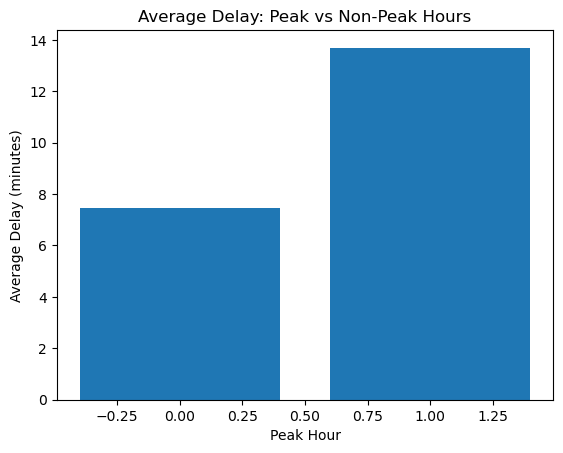

In [50]:
plt.figure()
plt.bar(peak_eda["peak_hour"], peak_eda["avg_delay"])
plt.xlabel("Peak Hour")
plt.ylabel("Average Delay (minutes)")
plt.title("Average Delay: Peak vs Non-Peak Hours")
plt.show()


# Question

### How strongly does traffic affect delays?

In [38]:
traffic_eda = (
    df.groupby("traffic_level")
      .agg(
          avg_delivery_time=("actual_delivery_minutes", "mean"),
          delay_rate=("delay_minutes", lambda x: (x > 0).mean()),
          avg_delay=("delay_minutes", "mean")
      )
      .reset_index()
      .sort_values("avg_delay", ascending=False)
)

traffic_eda.round(2)


,traffic_level,avg_delivery_time,delay_rate,avg_delay
0,High,29.64,1.00,15.59
2,Medium,22.80,0.97,8.76
1,Low,17.66,0.70,3.50


# High Traffic Conditions
## Avg Delivery Time = 29.64 minutes
During high traffic, customers wait nearly 30 minutes on average — almost 2× the promised delivery time.

## Delay Rate = 100%
Every single order placed during high traffic is delayed.

## Avg Delay = 15.59 minutes
Customers experience severe delays, waiting over 15 minutes extra beyond promised time.

# Medium Traffic Conditions
## Avg Delivery Time = 22.80 minutes
Even under medium traffic, deliveries take over 22 minutes, exceeding the instant delivery promise.

## Delay Rate = 97%
Almost all orders are still delayed.

## Avg Delay = 8.76 minutes
Customers wait nearly 9 extra minutes on average.


# Low Traffic Conditions

## Avg Delivery Time = 17.66 minutes
Deliveries are relatively faster, but still above the lower promised SLA.

## Delay Rate = 70%
Even in favorable traffic conditions, 7 out of 10 orders are delayed.

## Avg Delay = 3.50 minutes
Delays are smaller but still noticeable.

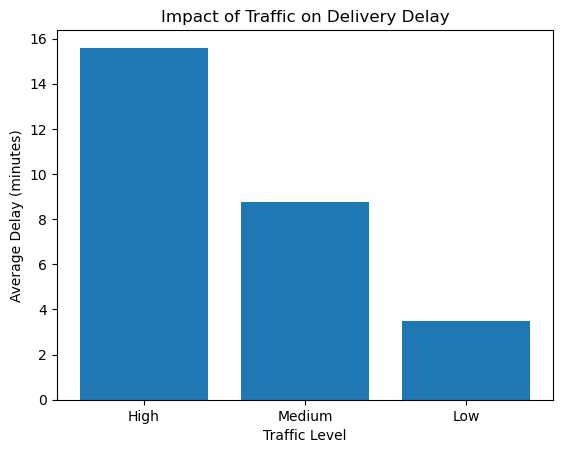

In [51]:
plt.figure()
plt.bar(traffic_eda["traffic_level"], traffic_eda["avg_delay"])
plt.xlabel("Traffic Level")
plt.ylabel("Average Delay (minutes)")
plt.title("Impact of Traffic on Delivery Delay")
plt.show()


# Weather Impact
## Question
Does rain significantly worsen delays?

In [40]:
weather_eda = (
    df.groupby("weather")
      .agg(
          avg_delivery_time=("actual_delivery_minutes", "mean"),
          delay_rate=("delay_minutes", lambda x: (x > 0).mean()),
          avg_delay=("delay_minutes", "mean")
      )
      .reset_index()
)

weather_eda.round(2)


,weather,avg_delivery_time,delay_rate,avg_delay
0,Clear,21.26,0.87,7.16
1,Rain,29.30,1.00,15.28


# Clear Weather Conditions
## Avg Delivery Time = 21.26 minutes
Even under clear weather, customers wait over 21 minutes on average, which exceeds the instant delivery promise.

## Delay Rate = 87%
Nearly 9 out of 10 orders are delayed even when weather conditions are favorable.

## Avg Delay = 7.16 minutes
Customers typically wait 7 extra minutes beyond promised time.



# Rainy Weather Conditions
## Avg Delivery Time = 29.30 minutes
During rain, delivery time increases to almost 30 minutes, nearly double the promised SLA.

## Delay Rate = 100%
Every order placed during rain is delayed.

## Avg Delay = 15.28 minutes
Customers wait over 15 extra minutes beyond promised time.



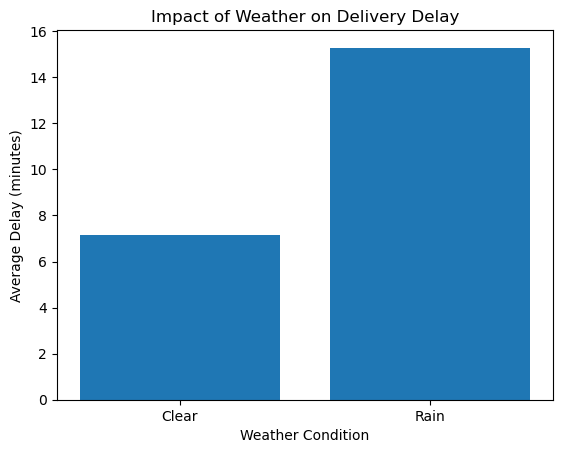

In [52]:
plt.figure()
plt.bar(weather_eda["weather"], weather_eda["avg_delay"])
plt.xlabel("Weather Condition")
plt.ylabel("Average Delay (minutes)")
plt.title("Impact of Weather on Delivery Delay")
plt.show()


# Rider Availability Impact

In [42]:
rider_eda = (
    df.groupby("rider_available")
      .agg(
          avg_delivery_time=("actual_delivery_minutes", "mean"),
          delay_rate=("delay_minutes", lambda x: (x > 0).mean()),
          avg_delay=("delay_minutes", "mean")
      )
      .reset_index()
)

rider_eda.round(2)


,rider_available,avg_delivery_time,delay_rate,avg_delay
0,No,29.68,1.00,15.65
1,Yes,22.14,0.88,8.05


# Rider Not Available (No)

## Avg Delivery Time = 29.68 minutes
When a rider is not immediately available, customers wait nearly 30 minutes for their order.

## Delay Rate = 100%
Every order placed when riders are unavailable is delayed.

## Avg Delay = 15.65 minutes
Customers experience severe delays, waiting over 15 extra minutes beyond promised time.


# Rider Available (Yes)
## Avg Delivery Time = 22.14 minutes

Even when riders are available, deliveries still take over 22 minutes, exceeding SLA.

## Delay Rate = 88%

Nearly 9 out of 10 orders are still delayed despite rider availability.

## Avg Delay = 8.05 minutes
Delays are smaller but still significant.

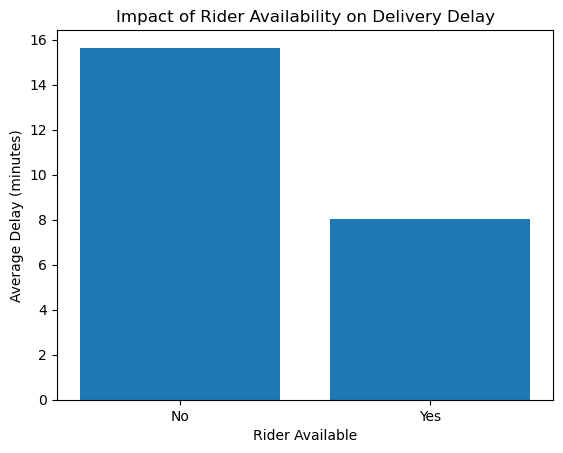

In [53]:
plt.figure()
plt.bar(rider_eda["rider_available"], rider_eda["avg_delay"])
plt.xlabel("Rider Available")
plt.ylabel("Average Delay (minutes)")
plt.title("Impact of Rider Availability on Delivery Delay")
plt.show()


In [29]:
df.head(1)

,order_id,order_date,city,order_hour,promised_minutes,traffic_level,weather,rider_available,peak_hour,actual_delivery_minutes,delay_minutes
0,1,2024-01-01,Delhi,22,10,High,Clear,Yes,True,33.3,23.3


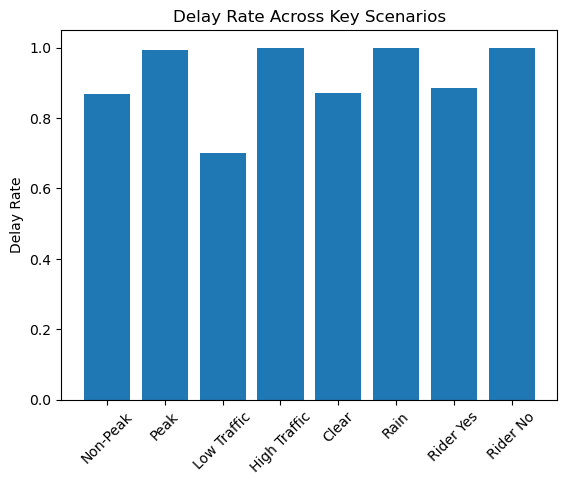

In [54]:
comparison_df = pd.DataFrame({
    "Scenario": ["Non-Peak", "Peak", "Low Traffic", "High Traffic", "Clear", "Rain", "Rider Yes", "Rider No"],
    "Delay Rate": [
        peak_eda.loc[peak_eda["peak_hour"] == False, "delay_rate"].values[0],
        peak_eda.loc[peak_eda["peak_hour"] == True, "delay_rate"].values[0],
        traffic_eda.loc[traffic_eda["traffic_level"] == "Low", "delay_rate"].values[0],
        traffic_eda.loc[traffic_eda["traffic_level"] == "High", "delay_rate"].values[0],
        weather_eda.loc[weather_eda["weather"] == "Clear", "delay_rate"].values[0],
        weather_eda.loc[weather_eda["weather"] == "Rain", "delay_rate"].values[0],
        rider_eda.loc[rider_eda["rider_available"] == "Yes", "delay_rate"].values[0],
        rider_eda.loc[rider_eda["rider_available"] == "No", "delay_rate"].values[0],
    ]
})

plt.figure()
plt.bar(comparison_df["Scenario"], comparison_df["Delay Rate"])
plt.xticks(rotation=45)
plt.ylabel("Delay Rate")
plt.title("Delay Rate Across Key Scenarios")
plt.show()


# Root Cause Analysis (RCA)

## Problem KPI

### Exploratory Data Analysis shows that the delay rate is extremely high (90%), and the on-time delivery percentage is very low (10%), indicating a serious service-level failure in the instant delivery system.

# Step 1: What I found using EDA (WHAT is happening)

## Using EDA, I found that:

##### About 90% of orders are delayed

##### Only ~10% of orders are delivered on time

##### Delays are much worse during peak hours

##### Delays increase when traffic is high

##### Rainy weather increases delays

##### When riders are not available, all orders are delayed

# Step 2: Why this is happening (RCA – WHY it is happening)

## Based on these EDA results:

##### During peak hours, order volume increases but delivery capacity does not increase enough.

##### High traffic slows down deliveries and makes the promised delivery time unrealistic.

##### Rain further slows deliveries but mainly worsens existing delays.

##### When riders are not available, orders wait before delivery starts, which causes guaranteed delays.

# Step 3: Main root cause

## Among all factors:

#### Rider availability is the most important root cause because whenever riders are unavailable, the delay rate becomes 100%.

#### Traffic and weather are external factors, but rider availability is something the company can control.

# Step 4: Simple RCA conclusion (THIS IS KEY)

##### I used EDA to identify where delivery delays were happening and then applied RCA to understand why they were happening. The analysis showed that rider availability and peak-hour capacity issues are the main reasons for delays, while traffic and weather increase the severity of the problem.

# 🧠 Final  Decision



### Increase rider availability during peak hours by using demand forecasting and rider incentives to reduce delivery delays and improve on-time delivery performance.

“Based on EDA and RCA, I decided that increasing rider availability during peak hours is the most effective and controllable action to reduce delivery delays.”

# 📊 MONITORING PLAN

# 🎯 Goal of Monitoring Plan
### After applying the decision (increase rider availability during peak hours), how do we check if delivery performance is improving or not?

### Compare before decision vs after decision.

# monitor each KPI
| KPI                 | How Often      | Expected Improvement        |
| ------------------- | -------------- | --------------------------- |
| On-Time %           | Daily / Weekly | Should increase             |
| Delay Rate          | Daily / Weekly | Should decrease             |
| Avg Delay           | Weekly         | Should decrease             |
| Peak-Hour Avg Delay | Daily          | Should reduce significantly |


# to check results after some days to increase my performance 

## Simple success benchmarks

###  On-Time % increases from ~10% → 30%+

### Delay Rate drops from ~90% → below 70%

### Avg Delay reduces by at least 20–30%

### Peak-hour delays show clear reduction

# What if KPIs do NOT improve

## If KPIs don’t improve:

### Re-evaluate rider incentives

### Increase rider count further

### Combine with traffic-based ETA adjustment

### Limit order intake during peak hours